# MLflow Tutorial

MLflow is an open source platform for managing the end-to-end machine learning lifecycle. In this notebook we will walk through some of its capabilities focusing on how tracking works, what a project is, and MLflow models.

If you don't have MLflow installed install it using the cell below.

In [38]:
%pip install mlflow

Note: you may need to restart the kernel to use updated packages.


### Create a Project 

Next we will create a project. This will reqire making an MLproject file and yaml file. These are important for packaging a project so that other Data Scientists can easily reuse the model or so that you can run the training remotely, for example Databricks.

The MLproject file specifies entry points, name, and conda environment file for the project.

In [1]:
%%writefile "MLproject"

name: tutorial

conda_env: conda.yaml

entry_points:
  main:
    parameters:
      alpha: {type: float, default: 0.01}
      l1_ratio: {type: float, default: 0.1}

Overwriting MLproject


In [34]:
with open('MLproject') as f:
    print(f.read())


name: tutorial

conda_env: conda.yaml

entry_points:
  main:
    parameters:
      alpha: {type: float, default: 0.01}
      l1_ratio: {type: float, default: 0.1}
    command: "python train_diabetes.py {alpha} {l1_ratio}"



The yaml file specifies the projects dependencies.

In [3]:
%%writefile "conda.yaml"

name: tutorial
channels:
  - defaults
  - anaconda
  - conda-forge
dependencies:
  - cloudpickle=0.6.1
  - python=3.6
  - numpy=1.14.3
  - matplotlib=3.0.2
  - pandas=0.22.0
  - scikit-learn=0.19.1
  - pip
  - pip:
    - mlflow

Overwriting conda.yaml


In [35]:
with open('conda.yaml') as f:
    print(f.read())


name: tutorial
channels:
  - defaults
  - anaconda
  - conda-forge
dependencies:
  - cloudpickle=0.6.1
  - python=3.6
  - numpy=1.14.3
  - matplotlib=3.0.2
  - pandas=0.22.0
  - scikit-learn=0.19.1
  - pip
  - pip:
    - mlflow



### Import libraries

Importing the required libraries for this tutorial.

In [20]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets
import mlflow
import mlflow.sklearn
from mlflow import log_param, log_metric, log_artifact, start_run, set_tag, register_model
from mlflow.sklearn import log_model

### Set tracking uri

Often in industry information relating to the ML life cycle is useful to multiple parties. To create accessablility this information can be stored on a remote server where multiple parties have access. In MLflow we can specify what server information is sent to by setting the tracking server.

In [ ]:
remote_server_uri = "http://38.102.178.57:5000" # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
# Note: on Databricks, the experiment name passed to mlflow_set_experiment must be a
# valid path in the workspace

### Set Experiment

Setting the experiment lets MLflow know what experiment the next run should be logged under. Other experiments with the same name are grouped together so that differences between runs are easy to see.

In [6]:
mlflow.set_experiment("another-experiment")

Traceback (most recent call last):
  File "C:\Users\ChristopherBowers\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "C:\Users\ChristopherBowers\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\ChristopherBowers\anaconda3\lib\site-packages\mlflow\utils\file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file 'C:\Users\ChristopherBowers\Documents\azure-intelligent-edge-patterns\Research\mlflow-on-azure-stack\notebooks\mlruns\1\meta.yaml' does not exist.
Traceback (most recent call last):
  File "C:\Users\ChristopherBowers\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 197, in list_experiments
    experiment = sel

INFO: 'another-experiment' does not exist. Creating a new experiment


### Create the Model

The code in the cell below loads the UCI diabetes data set, performs a train test split, trains an Elastic Net model, and makes predictions on the test data set. The rmse, mae, and r2 metrics evaluating these predictions are printed below this cell.

In [7]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)    
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target
Y = np.array([y]).transpose()
d = np.concatenate((X, Y), axis=1)
cols = diabetes.feature_names + ['progression']
data = pd.DataFrame(d, columns=cols)
train, test = train_test_split(data, random_state=40)
train_x = train.drop(["progression"], axis=1)
test_x = test.drop(["progression"], axis=1)
train_y = train[["progression"]]
test_y = test[["progression"]]
alpha = 0.05
l1_ratio = 0.05

lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
lr.fit(train_x, train_y)
predicted_qualities = lr.predict(test_x)
(rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

Elasticnet model (alpha=0.050000, l1_ratio=0.050000):
  RMSE: 78.59248628523486
  MAE: 66.30996047256438
  R2: 0.06607454600721252


### Logging model data and meta data

We will now start an mlflow run. Any metrics, parameters, tags or artifacts can now be logged for this run. Here, we have logged the alpha and l1 ratio parameters and the rmse, mae, and r2 metrics. We've also added a tag to indicate who the author of this run is and a description of this run as tags. In addition to parameters and metrics artifacts can be logged. The last line of code here logs the model we've created and registers it as 'ElasticnetDiabetesModel'.

Much like experiments registered models have a history. Lineage, versionoing, stage transitions, and annotations are all recorded and kept track of.

In [21]:
start_run()
set_tag("author", "name")
set_tag("description", "tutorial data based on the diabetes data set using an elastic net model")
log_param("alpha", alpha)
log_param("l1_ratio", l1_ratio)
log_metric("rmse", rmse)
log_metric("r2", r2)
log_metric("mae", mae)
log_model(lr, artifact_path=remote_server_uri + '/mlruns/4/model', registered_model_name='ElasticnetDiabetesModel')

TypeError: register_model() missing 1 required positional argument: 'model_uri'

### Logging other artifacts

Other artifacts can be logged from runs as well. the script below creates a plot of the regularization path using the elastic net. The last line logs that graph to this run as an artifact.

Computing regularization path using the elastic net.


MlflowException: Invalid artifact path: './mlruns/4/'. Names may be treated as files in certain cases, and must not resolve to other names when treated as such. This name would resolve to 'mlruns/4'

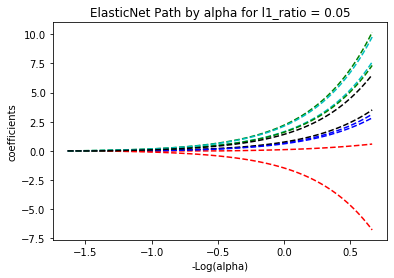

In [25]:
eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the elastic net.")
alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=l1_ratio, fit_intercept=False)

fig = plt.figure(1)
ax = plt.gca()
colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_e, c in zip(coefs_enet, colors):
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)
    

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
title = 'ElasticNet Path by alpha for l1_ratio = ' + str(l1_ratio)
plt.title(title)
plt.axis('tight')

fig.savefig("ElasticNet-paths.png")
log_artifact("ElasticNet-paths.png", artifact_path='./mlruns/4/')
mlflow.end_run()

### View Experiments

You can view your experiments by copying your remote server uri (in this case http://38.102.178.57:5000) into a web browser and selecting the experiment of interest. It should look something like this:
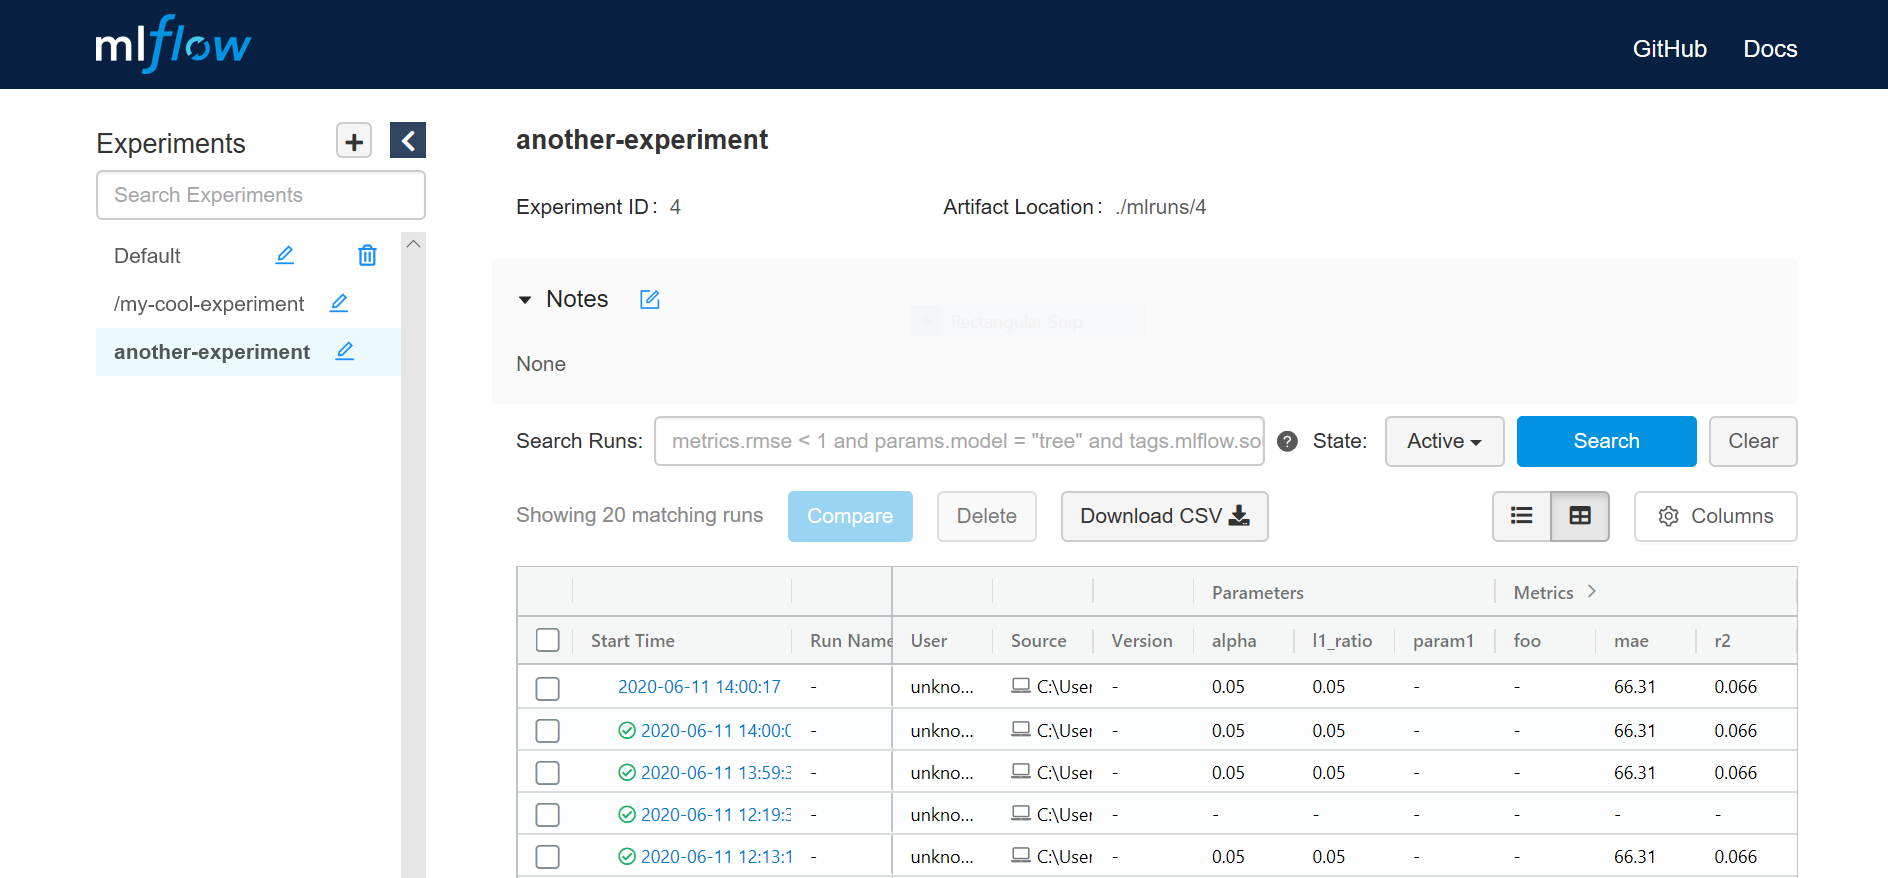

Experiments can also be quarried from this page using "Search Runs" with logic. For example, if we wanted to see if our elastic net models mae metric can compete with a boosted regression models mae we could search `metrics.rmse <= 66.31 and params.model="boosted regression`. This allows us to easily see all the boosted regression models that outperformed our elastic net. 

### MLflow Command Line Interface

So far we've explored the basics of MLflow but what if we wanted to automate running these tests so we could run large batches? MLflow has many usful functions to facilitate this but first we'll need to create a .py file. The cell below will write the python code we've written up to here to a .py file. The only adjustment has been to set the hyperparameters to be dependent on values given on the command line.

In [22]:
%%writefile "tutorial.py"

import os
import warnings
import sys

import pandas as pd
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets
import mlflow
import mlflow.sklearn
from mlflow import log_param, log_metric, log_artifact, start_run, set_tag
from mlflow.sklearn import log_model

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)    
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

if __name__ == "__main__":
    diabetes = datasets.load_diabetes()
    X = diabetes.data
    y = diabetes.target
    Y = np.array([y]).transpose()
    d = np.concatenate((X, Y), axis=1)
    cols = diabetes.feature_names + ['progression']
    data = pd.DataFrame(d, columns=cols)
    train, test = train_test_split(data, random_state=40)
    train_x = train.drop(["progression"], axis=1)
    test_x = test.drop(["progression"], axis=1)
    train_y = train[["progression"]]
    test_y = test[["progression"]]

    alpha = float(sys.argv[1]) if len(sys.argv) > 1 else 0.05
    l1_ratio = float(sys.argv[2]) if len(sys.argv) > 2 else 0.05

    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_x, train_y)
    predicted_qualities = lr.predict(test_x)
    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    start_run()
    set_tag("author", "name")
    set_tag("description", "tutorial data based on the diabetes data set using an elastic net model")
    log_param("alpha", alpha)
    log_param("l1_ratio", l1_ratio)
    log_metric("rmse", rmse)
    log_metric("r2", r2)
    log_metric("mae", mae)
    log_model(lr, artifact_path=remote_server_uri + '/mlruns/4/model', registered_model_name='ElasticnetDiabetesModel')

    eps = 5e-3  # the smaller it is the longer is the path

    print("Computing regularization path using the elastic net.")
    alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=l1_ratio, fit_intercept=False)

    fig = plt.figure(1)
    ax = plt.gca()
    colors = cycle(['b', 'r', 'g', 'c', 'k'])
    neg_log_alphas_enet = -np.log10(alphas_enet)
    for coef_e, c in zip(coefs_enet, colors):
        l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    title = 'ElasticNet Path by alpha for l1_ratio = ' + str(l1_ratio)
    plt.title(title)
    plt.axis('tight')

    fig.savefig("ElasticNet-paths.png")
    #log_artifact("ElasticNet-paths.png", artifact_path='./mlruns/4/')
    mlflow.end_run()

Overwriting tutorial.py


Now that we have a .py we should make sure our MLproject file is pointing to it. We can do this by adding `command: "python train_diabetes.py {alpha} {l1_ratio}"` at the end of our MLproject file.

In [41]:
%%writefile "MLproject"

name: tutorial

conda_env: conda.yaml

entry_points:
  main:
    parameters:
      alpha: {type: float, default: 0.01}
      l1_ratio: {type: float, default: 0.1}
    command: "python tutorial.py {alpha} {l1_ratio}"

Overwriting MLproject


Now that the needed files are in place we are ready to run MLflow commands. Experiments can be run by using the run command, `mlflow run [OPTIONS] URI`. Below this experiment is being run with an alpha value of 0.6

*Run the below cell if your operating system is Windows*

In [42]:
%%cmd

mlflow run . -P alpha=0.6

Microsoft Windows [Version 10.0.18362.900]
(c) 2019 Microsoft Corporation. All rights reserved.

C:\Users\ChristopherBowers\Documents\azure-intelligent-edge-patterns\Research\mlflow-on-azure-stack\notebooks>
C:\Users\ChristopherBowers\Documents\azure-intelligent-edge-patterns\Research\mlflow-on-azure-stack\notebooks>mlflow run . -P alpha=0.6
Solving environment: ...working... done

icu-58.2             | 21.9 MB   | ########## | 100% 
cycler-0.10.0        | 13 KB     | ########## | 100% 
pyparsing-2.4.7      | 65 KB     | ########## | 100% 
pytz-2020.1          | 184 KB    | ########## | 100% 
sip-4.19.8           | 262 KB    | ########## | 100% 
cloudpickle-0.6.1    | 28 KB     | ########## | 100% 
kiwisolver-1.2.0     | 55 KB     | ########## | 100% 
zlib-1.2.11          | 117 KB    | ########## | 100% 
pandas-0.22.0        | 7.1 MB    | ########## | 100% 
openssl-1.0.2t       | 5.8 MB    | ########## | 100% 
tornado-6.0.4        | 604 KB    | ########## | 100% 
scipy-1.1.0          

2020/06/15 12:19:37 INFO mlflow.projects: === Creating conda environment mlflow-a0892db4dbabd0b23dbcc0619215ba3f43585c5d ===


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda


2020/06/15 12:23:08 INFO mlflow.projects: === Created directory C:\Users\CHRIST~1\AppData\Local\Temp\tmp2z8cskxr for downloading remote URIs passed to arguments of type 'path' ===
2020/06/15 12:23:08 INFO mlflow.projects: === Running command 'conda activate mlflow-a0892db4dbabd0b23dbcc0619215ba3f43585c5d && python tutorial.py 0.6 0.1' in run with ID '8514c6604545481286b26ba07a4006ad' === 

CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
If using 'conda activate' from a batch script, change your
invocation to 'CALL conda.bat activate'.

To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - cm

*Run the below cell if you are using Linux or Apple OS*

In [36]:
%%bash

mlflow run tutorial.py -P alpha=0.6

Couldn't find program: 'bash'


### Createing a Deployment Image

After running the experiment with many different configureations you find a model that suits your needs. Great! Now it's time to create a deployment image.

In MLflow this can be achieved through the build-docker command. This takes a given model and creates an image by the given name. Here we create an image from our (*figgure out how to get model uuid*) model named tutorial.

This image can then be deployed by using the run command. In the example below we direct MLflow to serve the model so that its end point is port 5001 on the local machine.

Lets test this by building the image and serving it locally.

*Run the below cell if your operating system is Windows.*

In [31]:
%%cmd

mlflow models build-docker -m "runs:/05984d2f508a40aca6b1597f22d7bb95/tutorial" -n "tutorial"

mlflow run -p 5001:8080 "tutorial"

Microsoft Windows [Version 10.0.18362.900]
(c) 2019 Microsoft Corporation. All rights reserved.

C:\Users\ChristopherBowers\Documents\azure-intelligent-edge-patterns\Research\mlflow-on-azure-stack\notebooks>
C:\Users\ChristopherBowers\Documents\azure-intelligent-edge-patterns\Research\mlflow-on-azure-stack\notebooks>mlflow models build-docker -m "runs:/05984d2f508a40aca6b1597f22d7bb95/tutorial" -n "tutorial"

C:\Users\ChristopherBowers\Documents\azure-intelligent-edge-patterns\Research\mlflow-on-azure-stack\notebooks>

Traceback (most recent call last):
  File "c:\users\christopherbowers\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\christopherbowers\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\ChristopherBowers\anaconda3\Scripts\mlflow.exe\__main__.py", line 7, in <module>
  File "c:\users\christopherbowers\anaconda3\lib\site-packages\click\core.py", line 764, in __call__
    return self.main(*args, **kwargs)
  File "c:\users\christopherbowers\anaconda3\lib\site-packages\click\core.py", line 717, in main
    rv = self.invoke(ctx)
  File "c:\users\christopherbowers\anaconda3\lib\site-packages\click\core.py", line 1137, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "c:\users\christopherbowers\anaconda3\lib\site-packages\click\core.py", line 1137, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "c:\users\christopherbowers\anaconda3\lib\site-pa

*Run the below cell if you are using Linux or Apple OS*

In [ ]:
%%bash

mlflow models build-docker -m "runs:/05984d2f508a40aca6b1597f22d7bb95/tutorial" -n "tutorial"

mlflow run -p 5001:8080 "tutorial"

We can now post data to the end point and recieve predictions back. The Python code below uses our test data from earlier to request predictions.

In [ ]:
import requests

predicted_qualities = requests.post(url=5001, data = test_x.to_csv())
(rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

In [ ]:
mlflow run -b "kubernetes" -c "manifest name"